In [3]:
# a. Load in a pre-trained CNN model trained on a large dataset
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# b. Freeze parameters (weights) in the model’s lower convolutional layers
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers in the base model

# c. Add a custom classifier with several layers of trainable parameters to the model
# Custom classifier (we flatten and add Dense layers after the convolutional base)
x = Flatten()(base_model.output)  # Flatten the output of the conv layers
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
x = Dense(256, activation='relu')(x)  # Another fully connected layer
x = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Create the full model
model = Model(inputs=base_model.input, outputs=x)  # Ensure correct output connection

# d. Train classifier layers on training data available for the task
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Load and preprocess training and validation data using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_data = train_datagen.flow_from_directory('path_to_data/', target_size=(224, 224), 
                                               batch_size=32, class_mode='binary', 
                                               classes=['cats', 'dogs'])  # Specify classes
val_data = val_datagen.flow_from_directory('path_to_data/', target_size=(224, 224), 
                                           batch_size=32, class_mode='binary', 
                                           classes=['cats', 'dogs'])  # Specify classes

# Train the model
history = model.fit(train_data, epochs=10, validation_data=val_data, verbose=1)

# e. Fine-tune hyperparameters and unfreeze more layers as needed
# Unfreeze some layers in the base model for fine-tuning
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

# Recompile the model after unfreezing layers (with a smaller learning rate)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(train_data, epochs=10, validation_data=val_data, verbose=1)

# Model performance evaluation
loss, accuracy = model.evaluate(val_data)
print(f'Validation Accuracy: {accuracy:.4f}')


Found 298 images belonging to 2 classes.
Found 298 images belonging to 2 classes.
Epoch 1/10


10/10 [==============================] - 39s 4s/step - loss: 0.7596 - accuracy: 0.5805 - val_loss: 0.5881 - val_accuracy: 0.5705
Epoch 2/10
10/10 [==============================] - 44s 5s/step - loss: 0.6388 - accuracy: 0.6174 - val_loss: 0.4525 - val_accuracy: 0.8121
Epoch 3/10
10/10 [==============================] - 40s 4s/step - loss: 0.5668 - accuracy: 0.7013 - val_loss: 0.3560 - val_accuracy: 0.8893
Epoch 4/10
10/10 [==============================] - 39s 4s/step - loss: 0.4716 - accuracy: 0.7919 - val_loss: 0.3557 - val_accuracy: 0.8423
Epoch 5/10
10/10 [==============================] - 40s 4s/step - loss: 0.4885 - accuracy: 0.7450 - val_loss: 0.2910 - val_accuracy: 0.8758
Epoch 6/10
10/10 [==============================] - 38s 4s/step - loss: 0.4151 - accuracy: 0.8221 - val_loss: 0.2661 - val_accuracy: 0.8926
Epoch 7/10
10/10 [==============================] - 39s 4s/step - loss: 0.40

1/1 [==============================] - 2s 2s/step


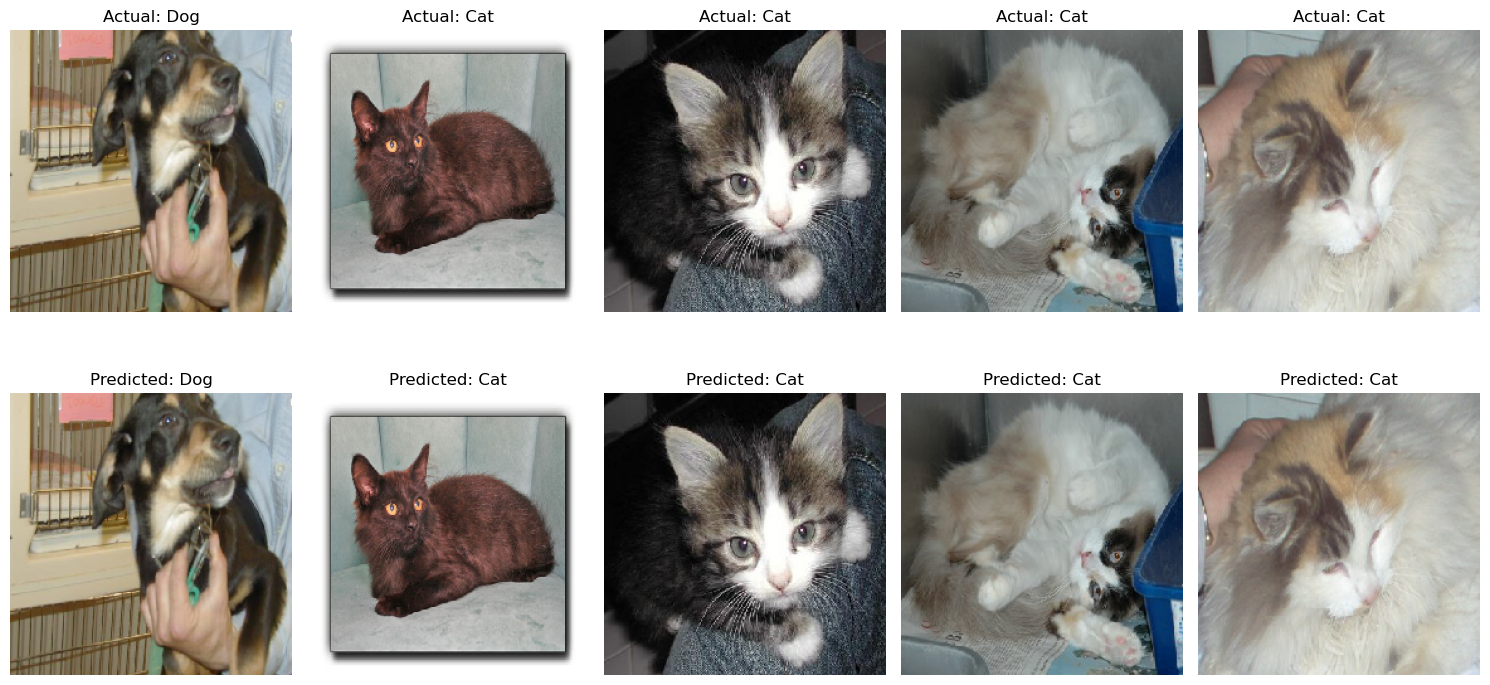

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array / 255.0  # Normalize to [0, 1] range

# Function to display images along with actual and predicted labels
def display_predictions(model, val_data, num_images=5):
    # Get a batch of validation data
    images, labels = next(iter(val_data))

    # Make predictions
    predictions = model.predict(images)

    # Convert predictions to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype("int32")

    # Set up the plot
    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        # Load the image and actual label
        img = images[i]
        actual_label = labels[i]
        predicted_label = predicted_classes[i]

        # Display the image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Actual: {"Dog" if actual_label == 1 else "Cat"}')

        # Display predicted label
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Predicted: {"Dog" if predicted_label == 1 else "Cat"}')

    plt.tight_layout()
    plt.show()

# Call the function to display predictions
display_predictions(model, val_data, num_images=5)  # Change num_images to display more or fewer images
